## Tutorial Overview: Essay Grading System

In this tutorial, we'll demonstrate the power of LangGraph by building a multi-step essay grading system. Our use case will focus on processing a given essay through four key stages:

1. **Content Relevance**: Assesses how well the essay addresses the given topic
2. **Grammar Check**: Evaluates the essay's language usage and grammatical correctness
3. **Structure Analysis**: Examines the organization and flow of ideas in the essay
4. **Depth of Analysis**: Gauges the level of critical thinking and insight presented

In [ ]:
from google.colab import userdata
userdata.get('secretName')

In [ ]:
%%capture
!pip install langchain langchain_core langchain_groq langchain_community langgraph

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
import re

Building The Essay Grading System Pipeline

1. State Definition
2. Langugage Model Initialization
3. Grading Node Function
4. Workflow Definition
5. Visualizing the Workflow
6. Essay Grading Function
7. Testing the Pipeline

##1. State Definition

In [ ]:
class State(TypedDict):
  essay: str
  relevance_score: float
  grammar_score: float
  structure_score: float
  depth_score: float
  final_score: float

##2. Langugae model initialization

In [ ]:
from langchain_groq import ChatGroq
from google.colab import userdata
llm = ChatGroq(
    temperature=0,
     groq_api_key = userdata.get('gro_api'),
    model_name="llama-3.3-70b-versatile"
)



##3. Grading Node Function

In [ ]:
def extract_score(content: str)->float:
  match_ = re.search(r'Score:\s*(\d+(\.\d+)?)', content)
  if match_:
    return float(match_.group(1))
  return ValueError(f"Could not extract score from : {content}")

def check_relevance(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the relevance of the following essay to the give topic. "
      "Provide a relevance score between 0 and 1"
      "Your response should start with 'Score: ' followed by numeric score, "
      "then provide your explanation .\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay = state["essay"]))
  try:
    state["relevance_score"] = extract_score(result.content)
  except ValueError as e:
    print(f"Error in check relevance: {e}")
    state["relevance_score"] = 0.0
  return state

def check_grammar(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the grammar and language of the following essay to the give topic. "
      "Provide a grammar score between 0 and 1"
      "Your response should start with 'Score: ' followed by numeric score, "
      "then provide your explanation .\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay = state["essay"]))
  try:
    state["grammar_score"] = extract_score(result.content)
  except ValueError as e:
    print(f"Error in check grammar: {e}")
    state["grammar_score"] = 0.0
  return state

def analyze_structure(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the structure of the following essay"
      "Provide a structure score between 0 and 1"
      "Your response should start with 'Score: ' followed by numeric score, "
      "then provide your explanation .\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay = state["essay"]))
  try:
    state["structure_score"] = extract_score(result.content)
  except ValueError as e:
    print(f"Error in structure_score: {e}")
    state["structure_score"] = 0.0
  return state

def evaluate_depth(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the depth of analysis in the following essay"
      "Provide a depth score between 0 and 1"
      "Your response should start with 'Score: ' followed by numeric score, "
      "then provide your explanation .\n\nEssay: {essay}"
  )
  result = llm.invoke(prompt.format(essay = state["essay"]))
  try:
    state["depth_score"] = extract_score(result.content)
  except ValueError as e:
    print(f"Error in depth_score: {e}")
    state["depth_score"] = 0.0
  return state

def calculate_final_score(state: State)->State:
  state["final_score"] = (
      state["relevance_score"] * 0.3 +
      state["grammar_score"] * 0.2+
      state["structure_score"] * 0.2+
      state["depth_score"] * 0.3
  )
  return state

##4. Workflow Definition

In [ ]:
workflow = StateGraph(State)

workflow.add_node("check_relevance", check_relevance)
workflow.add_node("check_grammar", check_grammar)
workflow.add_node("analyze_structure", analyze_structure)
workflow.add_node("evaluate_depth", evaluate_depth)
workflow.add_node("calculate_final_score", calculate_final_score)

workflow.add_conditional_edges(
    "check_relevance",
    lambda x: "check_grammar" if x["relevance_score"] > 0.5 else "calculate_final_score"
)

workflow.add_conditional_edges(
    "check_grammar",
    lambda x: "analyze_structure" if x["grammar_score"] > 0.5 else "calculate_final_score"
)
workflow.add_conditional_edges(
    "analyze_structure",
    lambda x: "evaluate_depth" if x["structure_score"] > 0.5 else "calculate_final_score"
)

workflow.add_conditional_edges(
    "evaluate_depth",
    lambda x: "calculate_final_score"
)

workflow.set_entry_point("check_relevance")

workflow.add_edge("calculate_final_score", END)

app = workflow.compile()


##5. Visualizing the Workflow

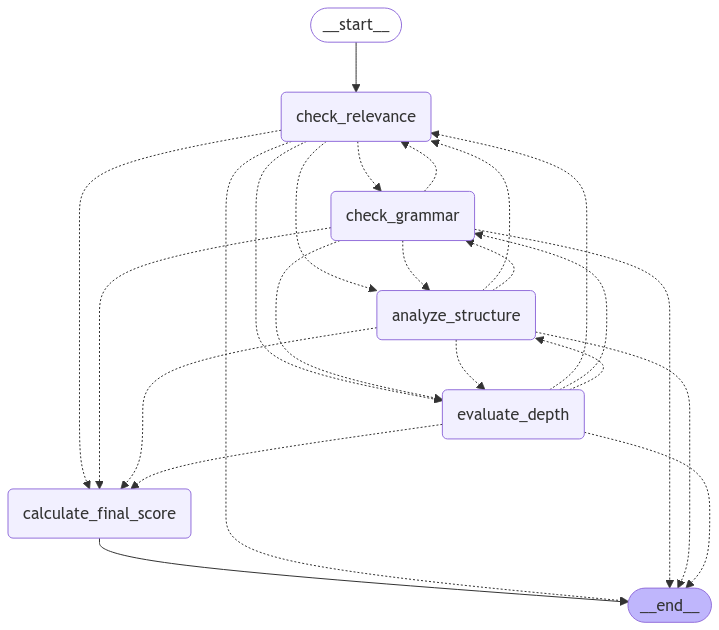

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

##6.Essay Grading Function

In [ ]:
def grade_essay(essay: str) ->dict:
  initial_state = State(
      essay = essay,
      relevance_score = 0.0,
      grammar_score = 0.0,
      structure_score= 0.0,
      depth_score = 0.0,
      final_score = 0.0
  )
  result = app.invoke(initial_state)
  return result

##7. Testing

In [ ]:
sample_essay = """
The Impact of Generative AI at Programming Society

Generative AI has revolutionized the programming landscape, driving profound changes
in how software is developed, learned, and maintained. One of the most significant
impacts is enhanced productivity. Tools like GitHub Copilot and ChatGPT assist developers
by generating code snippets, debugging, and automating repetitive tasks, allowing more
focus on innovation and problem-solving.

This technology has also democratized programming, lowering barriers for non-technical
users. With AI-powered no-code and low-code platforms, individuals with minimal programming
knowledge can build applications, fostering inclusivity and innovation across industries.
Furthermore, generative AI is transforming education, providing personalized learning
experiences and instant feedback to accelerate skill acquisition for aspiring developers.

Generative AI accelerates innovation by enabling rapid prototyping and exploration of new
ideas. However, it also reshapes the roles of developers, shifting their focus from raw
coding to designing workflows, managing AI models, and addressing ethical considerations.
This evolution creates new opportunities but also necessitates continuous upskilling to
meet changing demands in the job market.

The rise of generative AI brings challenges, including security vulnerabilities, ethical
concerns, and questions about code ownership. Developers must adopt robust validation
practices and ethical frameworks to mitigate these risks. Moreover, its influence on
open-source communities raises questions about authorship and licensing of AI-generated
contributions.

In conclusion, generative AI is transforming programming society, offering unparalleled
opportunities while introducing complex challenges. Its responsible integration will
define the future of software development and the role of developers in a rapidly
evolving technological landscape."""

result = grade_essay(sample_essay)

In [ ]:
print(f"Final Essay Score: {result['final_score']:.2f}\n")
print(f"Relevance Score: {result['relevance_score']:.2f}\n")
print(f"Grammar Score: {result['grammar_score']:.2f}\n")
print(f"Structure Score: {result['structure_score']:.2f}\n")
print(f"Depth Score: {result['depth_score']:.2f}\n")

Final Essay Score: 0.88

Relevance Score: 1.00

Grammar Score: 0.95

Structure Score: 0.90

Depth Score: 0.70



In [ ]:
# Home Work
# Gradio Interface